In [1]:
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
import tensorflow as tf 
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
df = pd.read_csv('fake_or_real_news.csv')
df.head()

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
x = df['title'] + ' ' + df['text']
y = pd.get_dummies(df['label'])
y = np.array(y)

In [5]:
x

0       You Can Smell Hillary’s Fear Daniel Greenfield...
1       Watch The Exact Moment Paul Ryan Committed Pol...
2       Kerry to go to Paris in gesture of sympathy U....
3       Bernie supporters on Twitter erupt in anger ag...
4       The Battle of New York: Why This Primary Matte...
                              ...                        
6330    State Department says it can't find emails fro...
6331    The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332    Anti-Trump Protesters Are Tools of the Oligarc...
6333    In Ethiopia, Obama seeks progress on peace, se...
6334    Jeb Bush Is Suddenly Attacking Trump. Here's W...
Length: 6335, dtype: object

In [6]:
y

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [0, 1]], dtype=uint8)

In [7]:
def clean_text(text, remove_stopwords = True):
 output = ''
 text = str(text).replace(r'http[\w:/\.]+','') # removing urls
 text = str(text).replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
 text = str(text).replace(r'\.\.+','.') #replace multiple periods with a single one
 text = str(text).replace(r'\.',' . ') #replace periods with a single one
 text = str(text).replace(r'\s\s+',' ') #replace multiple white space with a single one
 text = str(text).replace('\n', '') #removing line breaks
 text = re.sub(r'[^\w\s]','',text).lower() #lower texts
 if remove_stopwords:
  text = text.split(' ')
  for word in text:
   if word not in stopwords.words('english'):
     output = output + ' ' + word
   else:
     output = text
 return str(output.strip())[1:-3].replace(' ', ' ')


In [8]:
import nltk
nltk.download('stopwords')
texts = [] 
for line in tqdm_notebook(x, total=df.shape[0]): 
    texts.append(clean_text(line))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ouyan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\ouyan\AppData\Local\Temp\ipykernel_29364\2528164173.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(x, total=df.shape[0]):


  0%|          | 0/6335 [00:00<?, ?it/s]

TypeError: can only concatenate list (not "str") to list

In [ ]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ouyan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [ ]:
texts = [] 
for line in tqdm_notebook(x, total=df.shape[0]): 
 texts.append(clean_text(line))

NameError: name 'x' is not defined

In [ ]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train[0][0]

98

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [ ]:
X_train[0][0]

98

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        49664     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
# We are going to use early stop, which stops when the validation loss no longer improve.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=2,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/2
 257/1078 [======>.......................] - ETA: 1:03 - loss: 0.6266 - accuracy: 0.5633

KeyboardInterrupt: 

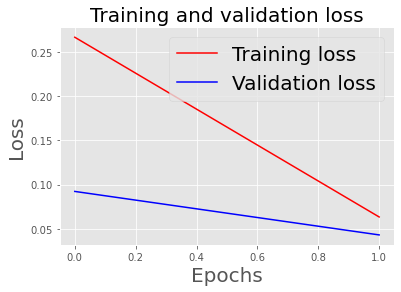

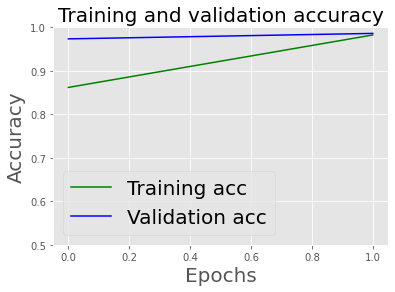

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 10s 37ms/step - loss: 0.0517 - accuracy: 0.9837


[0.05168655514717102, 0.9837416410446167]

In [ ]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

281/281 [==============================] - 12s 36ms/step


In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9837416481069042
Precision on testing set: 0.9768411301528486
Recall on testing set: 0.9892120075046904


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

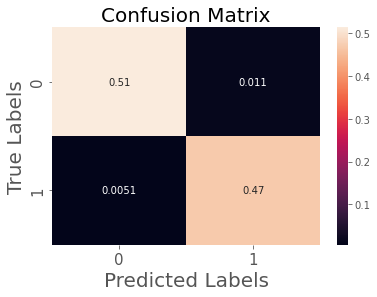

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(6,4))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [ ]:
word_index = list(tokenizer.word_index.keys())
word_index = word_index[:max_vocab-1]

In [ ]:
print(sys.path)

['c:\\Users\\ouyan\\OneDrive - Northeastern University\\Graduate\\2022 Spring ITC 6040 Informatics Capstone\\Code', 'c:\\Users\\ouyan\\anaconda3\\python39.zip', 'c:\\Users\\ouyan\\anaconda3\\DLLs', 'c:\\Users\\ouyan\\anaconda3\\lib', 'c:\\Users\\ouyan\\anaconda3', '', 'c:\\Users\\ouyan\\anaconda3\\lib\\site-packages', 'c:\\Users\\ouyan\\anaconda3\\lib\\site-packages\\win32', 'c:\\Users\\ouyan\\anaconda3\\lib\\site-packages\\win32\\lib', 'c:\\Users\\ouyan\\anaconda3\\lib\\site-packages\\Pythonwin']
